<a href="https://colab.research.google.com/github/premdub/AutoML/blob/main/autoML/autoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Pacakges

In [189]:
!pip install tpot mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [190]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML


# Options Available

- mode — the package ships with four built-in models. 
  - The Explain mode is ideal for explaining and understanding the data. It results in visualizations of feature importance as well as tree visualizations.
  - The Perform is used when building ML models for production. 
  - The Compete is meant to build models used in machine learning competitions. 
  - The Optuna mode is used to search for highly-tuned ML models.
- algorithms — specifies the algorithms you would like to use. They are usually passed in as a list.
- results_path — the path where the results will be stored
- total_time_limit — the total time in seconds for training the model
- train_ensemble — dictates if an ensemble will be created at the end of the training process
- stack_models — determines if a models stack will be created
- eval_metric — the metric that will be optimized. If auto the logloss is used for classification problems while the rmse is used for regression problems

In [191]:
#automl = AutoML(
    # mode="Explain"
    # algorithms=""
    # results_path="AutoML_22",
    # total_time_limit=30 * 60,
    # train_ensemble=True,
    # stack_models="",
    # eval_metric=""
#)

# Healthcare Dataset - Hospital Acquired Infection 

## Load in dataset

In [192]:
import pandas as pd
HAI = pd.read_csv('https://query.data.world/s/lcc3wkldiuom2xid5xlcn3bqpkk263')
HAI

Provider ID                           Hospital Name  \
0             10005           MARSHALL MEDICAL CENTER SOUTH   
1             10005           MARSHALL MEDICAL CENTER SOUTH   
2             10005           MARSHALL MEDICAL CENTER SOUTH   
3             10005           MARSHALL MEDICAL CENTER SOUTH   
4             10005           MARSHALL MEDICAL CENTER SOUTH   
...             ...                                     ...   
222859       351325                      ST LUKE'S HOSPITAL   
222860       471303  NORTHEASTERN VERMONT REGIONAL HOSPITAL   
222861       150026               IU HEALTH GOSHEN HOSPITAL   
222862        50038       SANTA CLARA VALLEY MEDICAL CENTER   
222863       140217  PRESENCE SAINT JOSEPH HOSPITAL - ELGIN   

                           Address             City State  ZIP Code  \
0       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
1       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
2       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
3       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
4       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
...                            ...              ...   ...       ...   
222859               702 1ST ST SW           CROSBY    ND     58730   
222860         1315 HOSPITAL DRIVE  SAINT JOHNSBURY    VT      5819   
222861           200 HIGH PARK AVE           GOSHEN    IN     46526   
222862     751 SOUTH BASCOM AVENUE         SAN JOSE    CA     95128   
222863         77 N AIRLITE STREET            ELGIN    IL     60123   

        County Name  Phone Number                    Measure Name  \
0          MARSHALL    2565938310  CLABSI: Lower Confidence Limit   
1          MARSHALL    2565938310  CLABSI: Upper Confidence Limit   
2          MARSHALL    2565938310    CLABSI: Number of Procedures   
3          MARSHALL    2565938310         CLABSI: Predicted Cases   
4          MARSHALL    2565938310          CLABSI: Observed Cases   
...             ...           ...                             ...   
222859       DIVIDE    7019656384           CAUTI: Observed Cases   
222860    CALEDONIA    8027487400   C.diff Lower Confidence Limit   
222861      ELKHART    5743641000    CLABSI: Number of Procedures   
222862  SANTA CLARA    4088855000      SSI: Colon Predicted Cases   
222863         KANE    8476953200     MRSA Lower Confidence Limit   

             Measure ID                  Compared to National          Score  \
0        HAI_1_CI_LOWER  No Different than National Benchmark          0.165   
1        HAI_1_CI_UPPER  No Different than National Benchmark          3.249   
2       HAI_1_DOPC_DAYS  No Different than National Benchmark           1485   
3       HAI_1_ELIGCASES  No Different than National Benchmark          2.034   
4       HAI_1_NUMERATOR  No Different than National Benchmark              2   
...                 ...                                   ...            ...   
222859  HAI_2_NUMERATOR                         Not Available  Not Available   
222860   HAI_6_CI_LOWER                         Not Available  Not Available   
222861  HAI_1_DOPC_DAYS  No Different than National Benchmark           1416   
222862  HAI_3_ELIGCASES     Worse than the National Benchmark          3.246   
222863   HAI_5_CI_LOWER  No Different than National Benchmark          0.219   

                                                 Footnote Measure Start Date  \
0                                                     NaN         01/01/2015   
1                                                     NaN         01/01/2015   
2                                                     NaN         01/01/2015   
3                                                     NaN         01/01/2015   
4                                                     NaN         01/01/2015   
...                                                   ...                ...   
222859  5 - Results are not available for this r

In [193]:
HAI.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Measure Name', 'Measure ID',
       'Compared to National', 'Score', 'Footnote', 'Measure Start Date',
       'Measure End Date', 'Location'],
      dtype='object')

## Potential variables of interest

- Measure ID (categorical) 
- Compared to National (continuous) 
- Score

In [194]:
HAI['Score'].describe()

count            222864
unique            21771
top       Not Available
freq             124717
Name: Score, dtype: object

In [195]:
HAI['Measure ID'].describe()

count             222864
unique                48
top       HAI_1_CI_LOWER
freq                4643
Name: Measure ID, dtype: object

In [196]:
HAI['Compared to National'].value_counts()

Not Available                           121398
No Different than National Benchmark     78324
Better than the National Benchmark       18108
Worse than the National Benchmark         5034
Name: Compared to National, dtype: int64

## Create some simplified binary versions

In [197]:
HAI['Score'] = pd.to_numeric(HAI['Score'], errors='coerce')
HAI['HAI_los'] = HAI['Score'].apply(lambda x: 'High-infection-rate' if x > 15 else 'Low-infection-rate')
HAI.drop('Score', axis=1, inplace=True)
HAI['HAI_los'].value_counts()


Low-infection-rate     200205
High-infection-rate     22659
Name: HAI_los, dtype: int64

# MLJar Examples

## Binary Classifier Example 1 - SPARCS

### **Create new model**

In [219]:
X = HAI.drop(columns=['HAI_los'])

In [220]:
y = HAI["HAI_los"]

In [221]:
X

Provider ID                           Hospital Name  \
0             10005           MARSHALL MEDICAL CENTER SOUTH   
1             10005           MARSHALL MEDICAL CENTER SOUTH   
2             10005           MARSHALL MEDICAL CENTER SOUTH   
3             10005           MARSHALL MEDICAL CENTER SOUTH   
4             10005           MARSHALL MEDICAL CENTER SOUTH   
...             ...                                     ...   
222859       351325                      ST LUKE'S HOSPITAL   
222860       471303  NORTHEASTERN VERMONT REGIONAL HOSPITAL   
222861       150026               IU HEALTH GOSHEN HOSPITAL   
222862        50038       SANTA CLARA VALLEY MEDICAL CENTER   
222863       140217  PRESENCE SAINT JOSEPH HOSPITAL - ELGIN   

                           Address             City State  ZIP Code  \
0       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
1       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
2       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
3       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
4       2505 U S HIGHWAY 431 NORTH             BOAZ    AL     35957   
...                            ...              ...   ...       ...   
222859               702 1ST ST SW           CROSBY    ND     58730   
222860         1315 HOSPITAL DRIVE  SAINT JOHNSBURY    VT      5819   
222861           200 HIGH PARK AVE           GOSHEN    IN     46526   
222862     751 SOUTH BASCOM AVENUE         SAN JOSE    CA     95128   
222863         77 N AIRLITE STREET            ELGIN    IL     60123   

        County Name  Phone Number                    Measure Name  \
0          MARSHALL    2565938310  CLABSI: Lower Confidence Limit   
1          MARSHALL    2565938310  CLABSI: Upper Confidence Limit   
2          MARSHALL    2565938310    CLABSI: Number of Procedures   
3          MARSHALL    2565938310         CLABSI: Predicted Cases   
4          MARSHALL    2565938310          CLABSI: Observed Cases   
...             ...           ...                             ...   
222859       DIVIDE    7019656384           CAUTI: Observed Cases   
222860    CALEDONIA    8027487400   C.diff Lower Confidence Limit   
222861      ELKHART    5743641000    CLABSI: Number of Procedures   
222862  SANTA CLARA    4088855000      SSI: Colon Predicted Cases   
222863         KANE    8476953200     MRSA Lower Confidence Limit   

             Measure ID                  Compared to National  \
0        HAI_1_CI_LOWER  No Different than National Benchmark   
1        HAI_1_CI_UPPER  No Different than National Benchmark   
2       HAI_1_DOPC_DAYS  No Different than National Benchmark   
3       HAI_1_ELIGCASES  No Different than National Benchmark   
4       HAI_1_NUMERATOR  No Different than National Benchmark   
...                 ...                                   ...   
222859  HAI_2_NUMERATOR                         Not Available   
222860   HAI_6_CI_LOWER                         Not Available   
222861  HAI_1_DOPC_DAYS  No Different than National Benchmark   
222862  HAI_3_ELIGCASES     Worse than the National Benchmark   
222863   HAI_5_CI_LOWER  No Different than National Benchmark   

                                                 Footnote Measure Start Date  \
0                                                     NaN         01/01/2015   
1                                                     NaN         01/01/2015   
2                                                     NaN         01/01/2015   
3                                                     NaN         01/01/2015   
4                                                     NaN         01/01/2015   
...                                                   ...                ...   
222859  5 - Results are not available for this reporti...         01/01/2015   
222860  5 - Results are not available for this reporti...         07/01/2014   
222861                                                NaN         01

In [222]:
y

0          Low-infection-rate
1          Low-infection-rate
2         High-infection-rate
3          Low-infection-rate
4          Low-infection-rate
                 ...         
222859     Low-infection-rate
222860     Low-infection-rate
222861    High-infection-rate
222862     Low-infection-rate
222863     Low-infection-rate
Name: HAI_los, Length: 222864, dtype: object

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [224]:
X_test

Provider ID                    Hospital Name  \
96518        190036           OCHSNER MEDICAL CENTER   
24561        291302       WILLIAM BEE RIRIE HOSPITAL   
78426        440081           LECONTE MEDICAL CENTER   
25736        450834            PHYSICIANS CENTRE,THE   
121317       140062         PALOS COMMUNITY HOSPITAL   
...             ...                              ...   
18479        370020               MERCY HOSPITAL ADA   
83313        351332  HEART OF AMERICA MEDICAL CENTER   
89198        521336   HAYWARD AREA MEMORIAL HOSPITAL   
200343       670056        SETON MEDICAL CENTER HAYS   
91246         40078     NATIONAL PARK MEDICAL CENTER   

                           Address           City State  ZIP Code County Name  \
96518           1516 JEFFERSON HWY    NEW ORLEANS    LA     70121   JEFFERSON   
24561                1500 AVENUE H            ELY    NV     89301  WHITE PINE   
78426         742 MIDDLECREEK ROAD    SEVIERVILLE    TN     37862  CUMBERLAND   
25736   3131 UNIVERSITY DRIVE EAST          BRYAN    TX     77802      BRAZOS   
121317     12251 SOUTH 80TH AVENUE  PALOS HEIGHTS    IL     60463        COOK   
...                            ...            ...   ...       ...         ...   
18479        430 NORTH MONTE VISTA            ADA    OK     74820    PONTOTOC   
83313               800 S MAIN AVE          RUGBY    ND     58368      PIERCE   
89198          11040 N STATE RD 77        HAYWARD    WI     54843      SAWYER   
200343              6001 KYLE PKWY           KYLE    TX     78640        HAYS   
91246          1910 MALVERN AVENUE    HOT SPRINGS    AR     71901     GARLAND   

        Phone Number                                       Measure Name  \
96518     5048423000                              C.diff Observed Cases   
24561     7752893001                     CLABSI: Lower Confidence Limit   
78426     8654467500                             CLABSI: Observed Cases   
25736     9797313100  Catheter-Associated Urinary Tract Infections (...   
121317    7089234000  Central line-associated bloodstream infections...   
...              ...                                                ...   
18479     5803322323                           CLABSI Central Line Days   
83313     7017765261  Clostridium difficile (C.diff.) Laboratory-ide...   
89198     7159344321  Catheter-Associated Urinary Tract Infections (...   
200343    5123245000                             CAUTI: Predicted Cases   
91246     5013211000  Clostridium difficile (C.diff.) Laboratory-ide...   

              Measure ID                  Compared to National  \
96518    HAI_6_NUMERATOR     Worse than the National Benchmark   
24561     HAI_1_CI_LOWER                         Not Available   
78426    HAI_1_NUMERATOR  No Different than National Benchmark   
25736         HAI_2a_SIR                         Not Available   
121317         HAI_1_SIR  No Different than National Benchmark   
...                  ...                                   ...   
18479   HAI_1a_DOPC_DAYS  No Different than National Benchmark   
83313          HAI_6_SIR                         Not Available   
89198         HAI_2a_SIR                         Not Available   
200343   HAI_2_ELIGCASES  No Different than National Benchmark   
91246          HAI_6_SIR  No Different than National Benchmark   

                                                 Footnote Measure Start Date  \
96518                                                 NaN         07/01/2014   
24561   12 - This measure does not apply to this hospi...         01/01/2015   
78426                                                 NaN         01/01/2015   
25736   12 - This measure does not apply to this hospi...         07/01/2014   
121317                                                NaN         01/01/2015   
...                                                   ...                ...   
18479   8 - The lower limit of the confidence interval...         07/01/2014   
83313   5 - Results are not 

In [228]:
automl = AutoML(results_path="HAI_binary_los", mode="Explain")

In [229]:
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: HAI_binary_los
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.328712 trained in 2.8 seconds
2_DecisionTree logloss 0.210423 trained in 35.04 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost logloss 0.028794 trained in 160.15 seconds
4_Default_NeuralNetwork logloss 0.225101 trained in 46.67 seconds
5_Default_RandomForest logloss 0.160248 trained in 34.95 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.028794 trained in 2.85 seconds
AutoML fit time: 300.36 seconds
AutoML best model: 3_Default_Xgboost


AutoML(results_path='HAI_binary_los')

In [231]:
pred = automl.predict(X_test)
pred

array(['High-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       ..., 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate'], dtype=object)

In [232]:
automl.report()

### **Test new (not really) data**

In [233]:
# load in the data model 

automl_HAI_los = AutoML(results_path="HAI_binary_los")

In [234]:
# create a new dataset that follows the same data structure as the training set
X_withlos = HAI.sample(25)
X_withoutlos = X_withlos.drop(columns=['HAI_los'])

In [235]:
X_withlos

Provider ID                                      Hospital Name  \
25016        240036                                  ST CLOUD HOSPITAL   
186616       220024                             HOLYOKE MEDICAL CENTER   
91953        100319                     FLORIDA HOSPITAL WESLEY CHAPEL   
217637        50008  CALIFORNIA PACIFIC MEDICAL CTR-DAVIES CAMPUS HOSP   
11432        390163                                      ACMH HOSPITAL   
89064        170104                     SHAWNEE MISSION MEDICAL CENTER   
178608       140197                      METHODIST HOSPITAL OF CHICAGO   
190149       450148    TEXAS HEALTH HARRIS METHODIST HOSPITAL CLEBURNE   
100856       201315                         STEPHENS MEMORIAL HOSPITAL   
150623       360107                                  BELLEVUE HOSPITAL   
56697        241309                          ESSENTIA HEALTH SANDSTONE   
147302       670019                        UNIVERSITY GENERAL HOSPITAL   
210165        51329                           SUTTER LAKESIDE HOSPITAL   
21195         50159                      VENTURA COUNTY MEDICAL CENTER   
107717        50773                               SAN LEANDRO HOSPITAL   
117910       180069             TUG VALLEY ARH REGIONAL MEDICAL CENTER   
146305       250097               SOUTHWEST MS REGIONAL MEDICAL CENTER   
4349         190027                       CHRISTUS ST PATRICK HOSPITAL   
186486        30055                    KINGMAN REGIONAL MEDICAL CENTER   
6017         261318                   SALEM MEMORIAL DISTRICT HOSPITAL   
141733       520096           WHEATON FRANCISCAN HEALTHCARE ALL SAINTS   
74011        420016                         SOUTHERN PALMETTO HOSPITAL   
191901       140083                                   LORETTO HOSPITAL   
140962       450688                     DALLAS REGIONAL MEDICAL CENTER   
51494        100157                   LAKELAND REGIONAL MEDICAL CENTER   

                              Address              City State  ZIP Code  \
25016              1406 6TH AVE NORTH       SAINT CLOUD    MN     56303   
186616               575 BEECH STREET           HOLYOKE    MA      1040   
91953         2600 BRUCE B DOWNS BLVD     WESLEY CHAPEL    FL     33544   
217637                 601 DUBOCE AVE     SAN FRANCISCO    CA     94117   
11432                 ONE NOLTE DRIVE        KITTANNING    PA     16201   
89064              9100 W 74TH STREET   SHAWNEE MISSION    KS     66204   
178608          5025 N PAULINA STREET           CHICAGO    IL     60640   
190149                201 WALLS DRIVE          CLEBURNE    TX     76033   
100856                181 MAIN STREET            NORWAY    ME      4268   
150623          1400 WEST MAIN STREET          BELLEVUE    OH     44811   
56697             109 COURT AVE SOUTH         SANDSTONE    MN     55072   
147302                    7501 FANNIN           HOUSTON    TX     77054   
210165            5176 HILL ROAD EAST          LAKEPORT    CA     95453   
21195              3291 LOMA VISTA RD           VENTURA    CA     93003   
107717            13855 E 14TH STREET       SAN LEANDRO    CA     94578   
117910             260 HOSPITAL DRIVE  SOUTH WILLIAMSON    KY     41503   
146305         215 MARION AV BOX 1307            MCCOMB    MS     39649   
4349    524 DR MICHAEL DEBAKEY STREET      LAKE CHARLES    LA     70601   
186486        3269 STOCKTON HILL ROAD           KINGMAN    AZ     86409   
6017                      PO BOX 774,             SALEM    MO     65560   
141733                 3801 SPRING ST            RACINE    WI     53405   
74011              811  REYNOLDS ROAD          BARNWELL    SC     29812   
191901          645 SOUTH CENTRAL AVE           CHICAGO    IL     60644   
140962     1011 NORTH GALLOWAY AVENUE          MESQUITE    TX     75149   
51494        1324 LAKELAND HILLS BLVD          LAKELAND    FL     33805   

          County Name  Phone Number  \
25016         STEARNS    3202512700   
186616        HAMPDEN    4135342500   
91953          

In [236]:
X_withoutlos

Provider ID                                      Hospital Name  \
25016        240036                                  ST CLOUD HOSPITAL   
186616       220024                             HOLYOKE MEDICAL CENTER   
91953        100319                     FLORIDA HOSPITAL WESLEY CHAPEL   
217637        50008  CALIFORNIA PACIFIC MEDICAL CTR-DAVIES CAMPUS HOSP   
11432        390163                                      ACMH HOSPITAL   
89064        170104                     SHAWNEE MISSION MEDICAL CENTER   
178608       140197                      METHODIST HOSPITAL OF CHICAGO   
190149       450148    TEXAS HEALTH HARRIS METHODIST HOSPITAL CLEBURNE   
100856       201315                         STEPHENS MEMORIAL HOSPITAL   
150623       360107                                  BELLEVUE HOSPITAL   
56697        241309                          ESSENTIA HEALTH SANDSTONE   
147302       670019                        UNIVERSITY GENERAL HOSPITAL   
210165        51329                           SUTTER LAKESIDE HOSPITAL   
21195         50159                      VENTURA COUNTY MEDICAL CENTER   
107717        50773                               SAN LEANDRO HOSPITAL   
117910       180069             TUG VALLEY ARH REGIONAL MEDICAL CENTER   
146305       250097               SOUTHWEST MS REGIONAL MEDICAL CENTER   
4349         190027                       CHRISTUS ST PATRICK HOSPITAL   
186486        30055                    KINGMAN REGIONAL MEDICAL CENTER   
6017         261318                   SALEM MEMORIAL DISTRICT HOSPITAL   
141733       520096           WHEATON FRANCISCAN HEALTHCARE ALL SAINTS   
74011        420016                         SOUTHERN PALMETTO HOSPITAL   
191901       140083                                   LORETTO HOSPITAL   
140962       450688                     DALLAS REGIONAL MEDICAL CENTER   
51494        100157                   LAKELAND REGIONAL MEDICAL CENTER   

                              Address              City State  ZIP Code  \
25016              1406 6TH AVE NORTH       SAINT CLOUD    MN     56303   
186616               575 BEECH STREET           HOLYOKE    MA      1040   
91953         2600 BRUCE B DOWNS BLVD     WESLEY CHAPEL    FL     33544   
217637                 601 DUBOCE AVE     SAN FRANCISCO    CA     94117   
11432                 ONE NOLTE DRIVE        KITTANNING    PA     16201   
89064              9100 W 74TH STREET   SHAWNEE MISSION    KS     66204   
178608          5025 N PAULINA STREET           CHICAGO    IL     60640   
190149                201 WALLS DRIVE          CLEBURNE    TX     76033   
100856                181 MAIN STREET            NORWAY    ME      4268   
150623          1400 WEST MAIN STREET          BELLEVUE    OH     44811   
56697             109 COURT AVE SOUTH         SANDSTONE    MN     55072   
147302                    7501 FANNIN           HOUSTON    TX     77054   
210165            5176 HILL ROAD EAST          LAKEPORT    CA     95453   
21195              3291 LOMA VISTA RD           VENTURA    CA     93003   
107717            13855 E 14TH STREET       SAN LEANDRO    CA     94578   
117910             260 HOSPITAL DRIVE  SOUTH WILLIAMSON    KY     41503   
146305         215 MARION AV BOX 1307            MCCOMB    MS     39649   
4349    524 DR MICHAEL DEBAKEY STREET      LAKE CHARLES    LA     70601   
186486        3269 STOCKTON HILL ROAD           KINGMAN    AZ     86409   
6017                      PO BOX 774,             SALEM    MO     65560   
141733                 3801 SPRING ST            RACINE    WI     53405   
74011              811  REYNOLDS ROAD          BARNWELL    SC     29812   
191901          645 SOUTH CENTRAL AVE           CHICAGO    IL     60644   
140962     1011 NORTH GALLOWAY AVENUE          MESQUITE    TX     75149   
51494        1324 LAKELAND HILLS BLVD          LAKELAND    FL     33805   

          County Name  Phone Number  \
25016         STEARNS    3202512700   
186616        HAMPDEN    4135342500   
91953          

In [237]:
predict = automl.predict(X_withoutlos)
predict

array(['Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'High-infection-rate', 'Low-infection-rate',
       'High-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate', 'Low-infection-rate', 'Low-infection-rate',
       'Low-infection-rate'], dtype=object)

In [238]:
# actual values from X_withlos
values_actual = X_withlos['HAI_los'].values.tolist()
values_predicted = predict.tolist()
output = pd.DataFrame({'actual': values_actual, 'predicted': values_predicted})
output

actual            predicted
0    Low-infection-rate   Low-infection-rate
1    Low-infection-rate   Low-infection-rate
2    Low-infection-rate   Low-infection-rate
3    Low-infection-rate   Low-infection-rate
4    Low-infection-rate   Low-infection-rate
5    Low-infection-rate   Low-infection-rate
6    Low-infection-rate   Low-infection-rate
7    Low-infection-rate   Low-infection-rate
8    Low-infection-rate   Low-infection-rate
9    Low-infection-rate   Low-infection-rate
10   Low-infection-rate   Low-infection-rate
11   Low-infection-rate   Low-infection-rate
12   Low-infection-rate   Low-infection-rate
13   Low-infection-rate   Low-infection-rate
14   Low-infection-rate   Low-infection-rate
15   Low-infection-rate   Low-infection-rate
16  High-infection-rate  High-infection-rate
17   Low-infection-rate   Low-infection-rate
18  High-infection-rate  High-infection-rate
19   Low-infection-rate   Low-infection-rate
20   Low-infection-rate   Low-infection-rate
21   Low-infection-rate   Low-infection-rate
22   Low-infection-rate   Low-infection-rate
23   Low-infection-rate   Low-infection-rate
24   Low-infection-rate   Low-infection-rate

## Binary Classifier Example 2 - GENERIC

In [214]:
import pandas as pd
from supervised.automl import AutoML
import os

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://raw.githubusercontent.com/hantswilliams/HHA-507-2022/main/autoML/datasets/data_binary_bank.csv")

X = df[df.columns[:-1]]
y = df["y"]

In [215]:
X

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
0      telephone   may         mon       261         1    999         0   
1      telephone   may         mon       149         1    999         0   
2      telephone   may         mon       226         1    999         0   
3      telephone   may         mon       151         1    999         0   
4      telephone   may         mon       307         1    999         0   
...          ...   ...         ...       ...       ...    ...       ...   
41183   cellular   nov         fri       334         1    999         0   
41184   cellular   nov         fri       383         1    999         0   
41185   cellular   nov         fri       189         2    999         0   
41186   cellular   nov         fri       442         1    999         0   
41187   cellular   nov         fri       239         3    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent           1.1          93.994          -36.4      4.857   
1      nonexistent           1.1          93.994          -36.4      4.857   
2      nonexistent           1.1          93.994          -36.4      4.857   
3      nonexistent           1.1          93.994          -36.4      4.857   
4      nonexistent           1.1          93.994          -36.4      4.857   
...            ...           ...             ...            ...        ...   
41183  nonexistent          -1.1          94.767          -50.8      1.028   
41184  nonexistent          -1.1          94.767          -50.8      1.028   
41185  nonexistent          -1.1          94.767          -50.8      1.028   
41186  nonexistent          -1.1          94.767          -50.8      1.028   
41187      failure          -1.1          94.767          -50.8      1.028   

       nr.employed  
0           5191.0  
1           5191.0  
2           5191.0  
3           5191.0  
4           5191.0  
...            ...  
41183       4963.6  
41184       4963.6  
41185       4963.6  
41186       4963.6  
41187       4963.6  

[41188 rows x 20 columns]

In [216]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)


Linear algorithm was disabled.
AutoML directory: AutoML_4
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.352021 trained in 1.81 seconds


KeyboardInterrupt: ignored

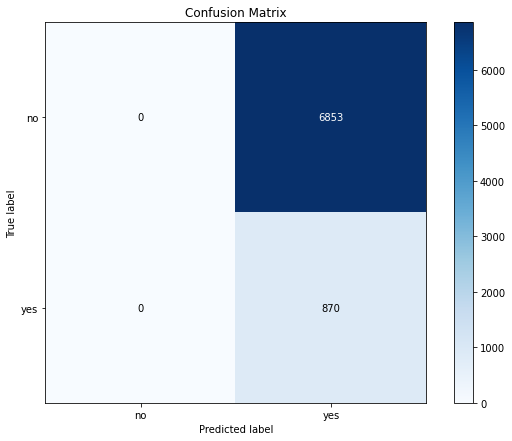

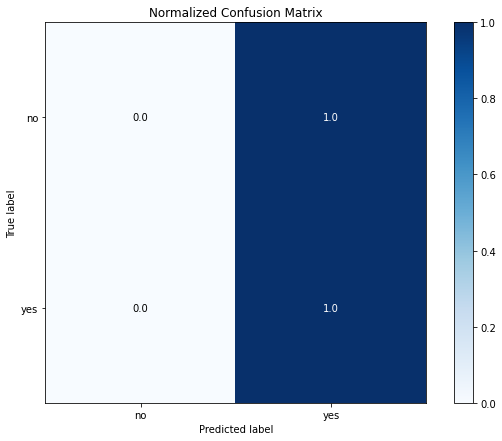

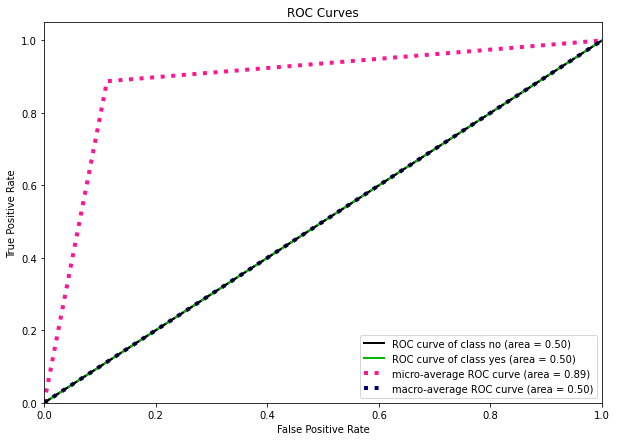

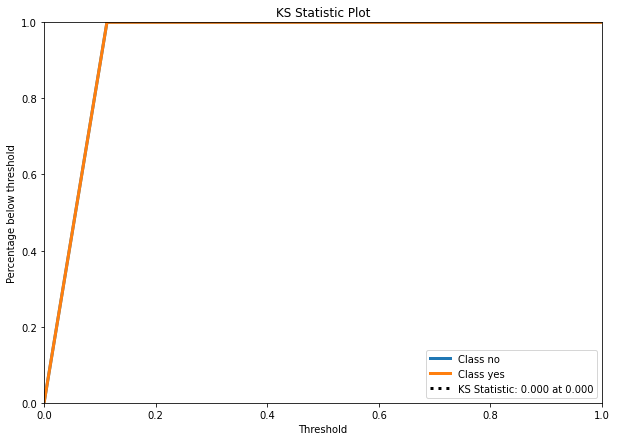

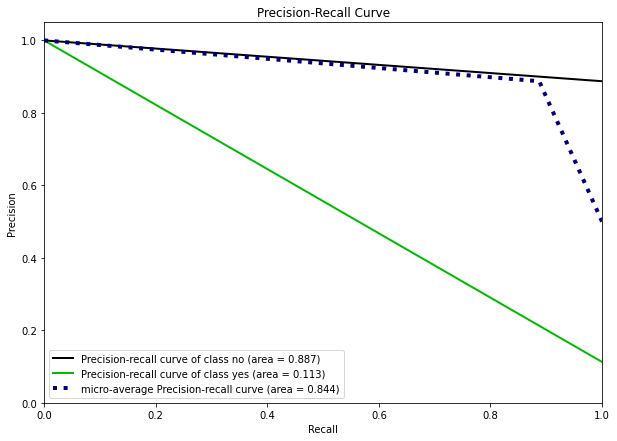

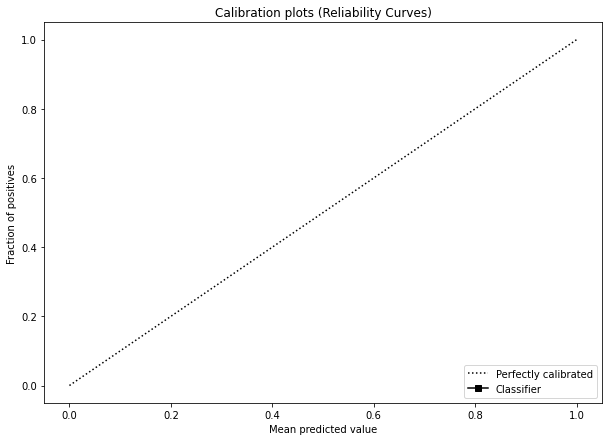

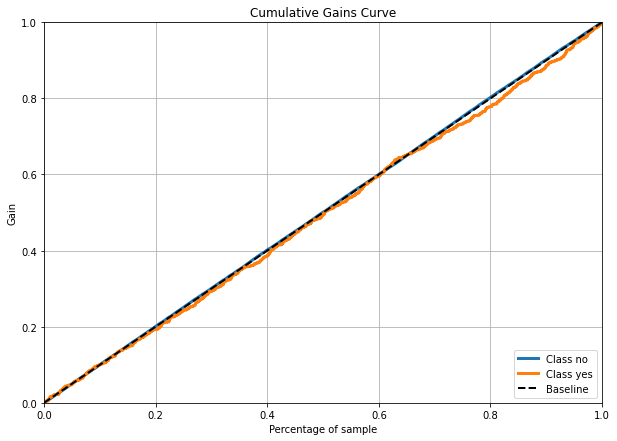

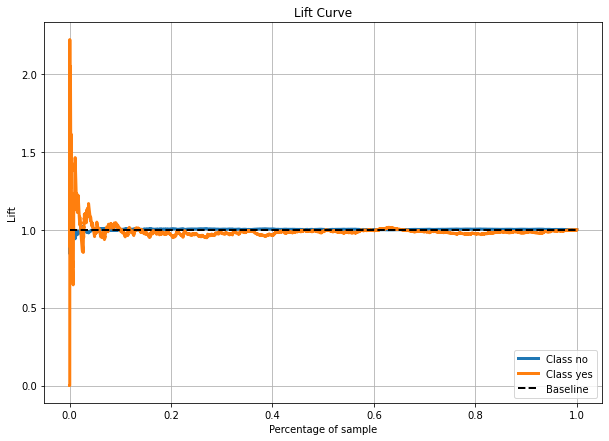

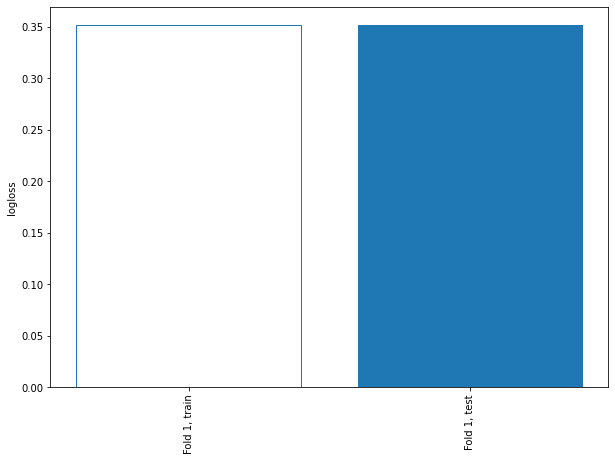

In [218]:
automl = AutoML(
    # results_path="AutoML_22",
    # total_time_limit=30 * 60,
    # start_random_models=10,
    # hill_climbing_steps=3,
    # top_models_to_improve=3,
    # train_ensemble=True,
    mode="Explain"
)

automl.fit(X_train, y_train)

In [ ]:
pred = automl.predict(X_test)
pred
# print("Test accuracy", accuracy_score(y_test, pred["label"]))

In [ ]:
automl.report()

## Regression - Example - GENERIC

## Regression - Example 2 - GENERIC

In [ ]:
import numpy as np
import pandas as pd
from supervised.automl import AutoML

df = pd.read_csv("https://raw.githubusercontent.com/hantswilliams/HHA-507-2022/main/autoML/datasets/data_regression_housing.csv")
x_cols = [c for c in df.columns if c != "MEDV"]
X = df[x_cols]
y = df["MEDV"]

In [ ]:
df

In [ ]:
x_cols

In [ ]:
X

In [ ]:
y

In [ ]:
automl = AutoML()
automl.fit(X, y)

In [ ]:
df["predictions"] = automl.predict(X)


In [ ]:
print("Predictions")
print(df[["MEDV", "predictions"]].head())

## Multiclass Classifier - GENERIC

In [ ]:
import pandas as pd
import numpy as np
from supervised.automl import AutoML
import supervised


import warnings

from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from supervised import AutoML
from supervised.exceptions import AutoMLException

# warnings.filterwarnings('error')
warnings.filterwarnings(
    "error", category=pd.core.common.SettingWithCopyWarning
)  # message="*ndarray*")

df = pd.read_csv("https://raw.githubusercontent.com/hantswilliams/HHA-507-2022/main/autoML/datasets/data_classes_iris.csv")
X = df[["feature_1", "feature_2", "feature_3", "feature_4"]]
y = df["class"]



In [ ]:
df

In [ ]:
X

In [ ]:
y.value_counts()

In [ ]:
automl = AutoML()


In [ ]:
automl.fit(X, y)

In [ ]:
predictions = automl.predict_all(X)


In [ ]:
print(predictions.head())
print(predictions.tail())

print(X.shape)
print(predictions.shape)

# Download outputs

In [239]:
# get current working directory
import os
os.getcwd()

'/content'

In [240]:
folders = os.listdir()
foldersML = [x for x in folders if x.startswith('HAI')]
print(foldersML)

['HAI_binary_los']


In [242]:
!zip -r /content/HAI_binary_los.zip /content/HAI_binary_los

updating: content/HAI_binary_los/ (stored 0%)
updating: content/HAI_binary_los/data_info.json (deflated 79%)
updating: content/HAI_binary_los/ldb_performance_boxplot.png (deflated 22%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/ (stored 0%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/ks_statistic.png (deflated 7%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/status.txt (stored 0%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/permutation_importance.png (deflated 19%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/learner_fold_0_importance.csv (deflated 35%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/cumulative_gains_curve.png (deflated 6%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/lift_curve.png (deflated 10%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/calibration_curve_curve.png (deflated 13%)
updating: content/HAI_binary_los/4_Default_NeuralNetwork/README.md (deflated 69%)
updating: